# Advanced ML Pipeline

Putting it all together from preceding lessons and labs

Dataset (CIFAR-10): https://www.cs.toronto.edu/~kriz/cifar.html

Model

In [5]:
# Imports

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import os
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt

from PIL import Image   # Python package: Pillow

In [6]:
# Data Inspection

# play around with just one file to understand how to load and process the data

file_path = './data/CIFAR-10-batches-py/data_batch_1'   # batch 1

with open(file_path, 'rb') as f:
    # batch_data_dict = pickle.load(f, encoding='bytes') # python dict keys would be binary and inaccessible using natural language
    batch_data_dict = pickle.load(f, encoding='latin1')
# print(batch_data_dict)

# for key in batch_data_dict:
#     print(key)

/var/folders/q6/cws687_10tb7d_q4kvb0d8t40000gn/T/ipykernel_42032/2235618905.py:9: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  batch_data_dict = pickle.load(f, encoding='latin1')


In [7]:
# Data Access: Define Dataset class

# Dataset: CIFAR-10

class CIFAR10Dataset(Dataset):
    """
    CIFAR-10 dataset from downloaded batch files
    """

    def __init__(self, root_dir, train=True, transform=None):
        self.root_dir = root_dir
        self.train = train
        self.transform = transform

        if not os.path.exists(self.root_dir):
            raise FileNotFoundError(f"CIFAR-10 directory not found: {self.root_dir}")

        self.data, self.labels = self._load_data()

    def _load_data(self):
        images_list = []
        labels_list = []

        batch_files = (
            [f"data_batch_{i}" for i in range(1, 6)]
            if self.train
            else ["test_batch"]
        )

        for batch_file in batch_files:
            path = os.path.join(self.root_dir, batch_file)
            images, labels = self._load_batch(path)
            images_list.append(images)
            labels_list.extend(labels)

        images = np.concatenate(images_list, axis=0)  # (N, 3, 32, 32)
        labels = np.array(labels_list, dtype=np.int64)

        return images, labels

    def _load_batch(self, file_path):
        with open(file_path, "rb") as f:
            batch = pickle.load(f, encoding="latin1")

        images = batch["data"]          # (10000, 3072)
        labels = batch["labels"]

        images = images.reshape(-1, 3, 32, 32)
        return images, labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        # Convert (C, H, W) NumPy -> (H, W, C) for PIL
        image = np.transpose(image, (1, 2, 0))
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)


In [8]:
# Utils
# put in own file for future usage

# def denormalize(img_denorm, mean_list=[0.485, 0.456, 0.406], std_list=[0.229, 0.224, 0.225]):

#     # @param [] mean_list: calculated list of means for the dataset such as [0.485, 0.456, 0.406] for OxfordFlowers
#     # @param [] std_list: calculated list of standard deviations for the dataset such as [0.229, 0.224, 0.225] for OxfordFlowers

#     mean = torch.tensor(mean_list).view(3, 1, 1)
#     std = torch.tensor(std_list).view(3, 1, 1)

#     img_denorm = img_denorm * std + mean
#     img_denorm = img_denorm.clamp(0, 1)

#     return img_denorm

import numpy as np
import torch

def denormalize(img, mean_list=[0.485, 0.456, 0.406], std_list=[0.229, 0.224, 0.225]):
    """
    Accepts:
      - torch.Tensor in CHW (preferred), OR
      - np.ndarray in CHW/HWC

    Returns:
      - torch.Tensor in CHW in [0,1]
    """
    # convert numpy -> torch
    if isinstance(img, np.ndarray):
        x = torch.from_numpy(img)
        # if HWC, convert to CHW
        if x.ndim == 3 and x.shape[-1] in (1, 3) and x.shape[0] not in (1, 3):
            x = x.permute(2, 0, 1)
        img = x.float()
    elif torch.is_tensor(img):
        img = img.float()
    else:
        raise TypeError(f"denormalize expects torch.Tensor or np.ndarray, got {type(img)}")

    # ensure CHW
    if img.ndim != 3:
        raise ValueError(f"Expected 3D image (C,H,W) or (H,W,C), got shape {tuple(img.shape)}")

    c = img.shape[0] if img.shape[0] in (1, 3) else img.shape[-1]
    if img.shape[0] not in (1, 3) and img.shape[-1] in (1, 3):
        img = img.permute(2, 0, 1)  # HWC -> CHW

    mean = torch.tensor(mean_list, dtype=img.dtype, device=img.device).view(3, 1, 1)
    std = torch.tensor(std_list, dtype=img.dtype, device=img.device).view(3, 1, 1)

    out = img * std + mean
    return out.clamp(0, 1)


def visualize_raw_image(raw_image_array):
    
    # @param <np.array> raw image input array from dataset before any processing

    img_reshaped = np.reshape(raw_image_array, (3, 32, 32))   # reshape to (C, H, W)
    img_permuted = np.transpose(img_reshaped, (1, 2, 0))  # convert to (H, W, C) for matplotlib

    plt.imshow(img_permuted)
    plt.axis("off")
    plt.show()

    # or visualize just raw image (not tensor) using Pillow


def visualize_processed_image(loader_data, mean_list=(0.485,0.456,0.406), std_list=(0.229,0.224,0.225)):
    
    # @param DataLoader loader_data: data loader obj of dataset such as training loader data 
    
    images, labels = next(iter(loader_data))
    processed_img = images[0].cpu()

    denorm = denormalize(processed_img, mean_list, std_list)   # CHW torch
    img_hwc = denorm.permute(1, 2, 0).numpy()

    plt.imshow(img_hwc)
    plt.axis("off")
    plt.show()


def visualize_data_augmentations(dataset, idx=0, num_versions=8, mean_list=(0.485,0.456,0.406), std_list=(0.229,0.224,0.225)):
    """ See what data augmentations look like for a sample image """
    # @param Tensor dataset: just raw dataset tensor, not passed into DataLoader

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()

    for i in range(num_versions):
        img, label = dataset[idx]  # could be np or torch depending on your dataset

        img = denormalize(img, mean_list, std_list)  # CHW torch
        axes[i].imshow(img.permute(1, 2, 0).numpy())
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

In [9]:
# Data Preprocessing: Define Transformations

# define transformations for each split dataset

transform_training_fn = transforms.Compose([
    # data augmentations
    transforms.RandomHorizontalFlip(p=0.5),

    # standard preprocessing
    # transforms.Resize(224), # since CIFAR-10 image is 32x32, no need to make smaller
    # transforms.CenterCrop(200), # 
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # TODO: create util to calc mean and std
        std=[0.229, 0.224, 0.225]
    )
])

transform_validation_fn = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(200),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # TODO: create util to calc mean and std
        std=[0.229, 0.224, 0.225]
    )
]) 

/var/folders/q6/cws687_10tb7d_q4kvb0d8t40000gn/T/ipykernel_42032/1497338952.py:43: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  batch = pickle.load(f, encoding="latin1")


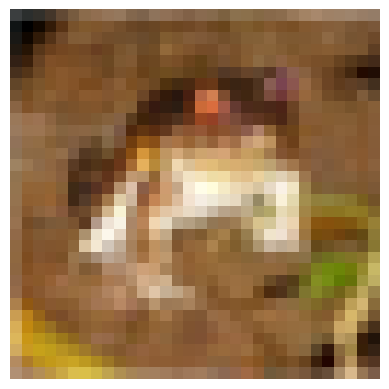

TypeError: Unexpected type <class 'numpy.ndarray'>

In [10]:
# Data Access: Sample Inspection

# inspect what transforms to apply to raw dataset

root_dir = './data/CIFAR-10-batches-py'
train_raw_dataset = CIFAR10Dataset(
    root_dir,
    train=True
)

RAW_IMAGE_INDEX = 0
raw_image_np_array = train_raw_dataset.data[RAW_IMAGE_INDEX]    # train dataset input images already transformed into tensors
visualize_raw_image(raw_image_np_array)


# Play around with which transformations or processing to apply (e.g., resizing, cropping, convert to tensors, etc.)

img = train_raw_dataset.data[0] # raw image np array
label = train_raw_dataset.labels[0]
img_resized = transforms.Resize(256)(img)
img_resized_cropped = transforms.CenterCrop(224)(img_resized)
img_tensor = transforms.ToTensor()(img_resized_cropped)

print(img_resized.size)

# print(img_resized.show())  # TODO: visualize raw image using Pillow
visualize_raw_image(img)

print(img_tensor)
print(img_tensor.shape)

In [11]:
# Data PreProcessing: Create actual split transformed datasets

import torch
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
import numpy as np

# -----------------------------
# Configuration
# -----------------------------
BATCH_SIZE = 128
NUM_WORKERS = 0
TRAIN_RATIO = 0.8
RANDOM_SEED = 42

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


# Base datasets (same data, different transforms)
# full train dataset will be split into train and val subsets, since test dataset is already provided for CIFAR-10
full_train_dataset = CIFAR10Dataset(
    root_dir=root_dir,
    train=True,
    transform=None  # transform applied in __getitem__ if to be added
)   # will split into train and validation subsets

test_dataset = CIFAR10Dataset(
    root_dir=root_dir,
    train=False,
    transform=None
)

dataset_size = len(full_train_dataset)
train_size = int(TRAIN_RATIO * dataset_size)
val_size = dataset_size - train_size

print(f"Train samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Test samples: {len(test_dataset)}")


# Create index split
# only splitting train and validation sets since test set exists already for CIFAR-10
indices = torch.randperm(dataset_size)
train_indices = indices[:train_size]
val_indices = indices[train_size:]


# Subsets
# only splitting train and validation sets since test set exists already for CIFAR-10
train_subset = Subset(full_train_dataset, train_indices)
val_subset = Subset(full_train_dataset, val_indices)

# Optional: wrap subsets to apply different transforms
class TransformSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        image, label = self.subset[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


train_dataset = CIFAR10Dataset(
    root_dir=root_dir,
    train=True,
    transform=transform_training_fn
)
train_dataset = Subset(train_dataset, train_indices)

val_dataset = CIFAR10Dataset(
    root_dir=root_dir,
    train=True,
    transform=transform_validation_fn
)
val_dataset = Subset(val_dataset, val_indices)

test_dataset = TransformSubset(
    test_dataset, 
    transform=transform_validation_fn
)


# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)



/var/folders/q6/cws687_10tb7d_q4kvb0d8t40000gn/T/ipykernel_42032/1497338952.py:43: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  batch = pickle.load(f, encoding="latin1")


Train samples: 40000
Validation samples: 10000
Test samples: 10000


In [12]:
# Model

# Basic model


class CNNBasic(nn.Module):

    def __init__(self):

        super().__init__()

        # input image size is 32 x 32 for dataset CIFAR-10
        # image size = 32

        # conv block 1
        self.conv1 = nn.Conv2d(
            in_channels=3,    # input channel = color channel (grayscale is 1, RGB is 3)
            out_channels=32,  # how many feature maps to produce
            kernel_size=3,   # filter size
            padding=1,  # filter padding
        )
        self.activation1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )


        # conv block 2
        # image size is halved due to preceding pooling
        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,  # how many feature maps to produce
            kernel_size=3,
            padding=1,
        )
        self.activation2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )

        # conv block 3
        self.conv3 = nn.Conv2d(
            in_channels=64,
            out_channels=128,  # how many feature maps to produce
            kernel_size=3,
            padding=1,
        )
        self.activation3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )


        # flatten
        self.flatten = nn.Flatten()

        # fully connected blocks
        flattened_size = 128 * 4 * 4    # prev layer's output channels * input tensor size after latest pooling
        fc_output = 256
        self.fc1 = nn.Linear(
            flattened_size,
            fc_output
        )
        self.activation_output = nn.ReLU()
        
        # output layer
        output_classes = 10
        final_layer_input = fc_output
        self.fc_output = nn.Linear(
            final_layer_input,
            output_classes
        )


    def forward(self, x):
        # conv block 1
        x = self.conv1(x)
        x = self.activation1(x) 
        x = self.pool1(x)

        # conv block 2
        x = self.conv2(x)
        x = self.activation2(x)
        x = self.pool2(x)

        # conv block 3
        x = self.conv3(x)
        x = self.activation3(x)
        x = self.pool3(x)


        # flatten
        x = self.flatten(x)

        # fully connected blocks
        x = self.fc1(x)
        x = self.activation_output(x)
        
        # output layer
        x = self.fc_output(x)

        return x
        



In [13]:
# Model Inspection

# get data batch for testing model
# img_batch, label_batch = next(iter(train_loader))
# print("Batch shape:", img_batch.shape)  # Should be [batch_size, 1, 28, 28] - color channel grayscale, image size 28x28

batch = next(iter(train_loader))
img_batch, label_batch = batch
print('img batch size: ', img_batch.size())

# initialize model on data batch
cnn_basic = CNNBasic()
cnn_basic(img_batch)
 

img batch size:  torch.Size([128, 3, 32, 32])


/Users/henryzheng/Desktop/machine-learning/pytorch-fundamentals/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


tensor([[-0.0617,  0.0149,  0.0243,  ...,  0.0415, -0.0446, -0.0477],
        [-0.0809,  0.0389,  0.0231,  ...,  0.0491, -0.0763, -0.0620],
        [-0.0655,  0.0433,  0.0381,  ...,  0.0384, -0.0608, -0.0114],
        ...,
        [-0.0845,  0.0422,  0.0143,  ...,  0.0394, -0.0616, -0.0626],
        [-0.1260,  0.0520,  0.0259,  ...,  0.0604, -0.0856, -0.0656],
        [-0.0492,  0.0309,  0.0129,  ...,  0.0474, -0.0624, -0.0282]],
       grad_fn=<AddmmBackward0>)

In [14]:
class CNNBasicDebug(CNNBasic):

    def __init__(self):

        super().__init__()

    def forward(self, x):

        print(f"Input shape: {x.shape}")

        print(
            "(Layer components) Conv layer 1 parameters (weights, biases) shapes:",
            self.conv1.weight.shape,
            self.conv1.bias.shape
        )

        x = self.conv1(x)
        x = self.activation1(x)
        
        print("(Activation) Tensor shape after convolution 1 and ReLU activation:", x.shape)
        
        x = self.pool1(x)

        print("(Activation) Tensor shape after pooling 1:", x.shape)
        
        print("---")

        print(
            "(Layer components) Conv layer 2 parameters (weights, biases) shapes:",
            self.conv2.weight.shape,
            self.conv2.bias.shape
        )

        x = self.conv2(x)
        x = self.activation2(x)
        
        print("(Activation) Tensor shape after convolution 2 and ReLU activation:", x.shape)
        
        x = self.pool2(x)

        print("(Activation) Tensor shape after pooling 2: ", x.shape)

        print("---")

        print(
            "(Layer components) Conv layer 3 parameters (weights, biases) shapes:",
            self.conv3.weight.shape,
            self.conv3.bias.shape
        )

        x = self.conv3(x)
        x = self.activation3(x)
        
        print("(Activation) Tensor shape after convolution 3 and ReLU activation:", x.shape)
        
        x = self.pool3(x)

        print("(Activation) Tensor shape after pooling 3:", x.shape)

        # Note: Addresses shape mismatch error between conv block and fully connected block by flattening the layer

        x = torch.flatten(
            x, start_dim=1
        )  # Flatten all dimensions except batch
        
        print("(Activation) After flattening:", x.shape)
        
        print("---")

        print(
            "(Layer components) Linear layer fc1",
            self.fc1.weight.shape,
            self.fc1.bias.shape
        )

        x = self.fc1(x)
        x = self.activation_output(x)

        print("(Activation) Tensor shape after fc1 and ReLU:", x.shape)
        
        print("---")
        
        print(
            "(Layer components) Linear layer fc2 parameters (weights, biases):",
            self.fc_output.weight.shape,
            self.fc_output.bias.shape,
        )
        x = self.fc_output(x)


        print("(Activation) After fc2 (output):", x.shape)

        print("---")
        
        return x

In [15]:
# Model debug

cnn_basic_debug = CNNBasicDebug()

cnn_basic_debug(img_batch)

Input shape: torch.Size([128, 3, 32, 32])
(Layer components) Conv layer 1 parameters (weights, biases) shapes: torch.Size([32, 3, 3, 3]) torch.Size([32])
(Activation) Tensor shape after convolution 1 and ReLU activation: torch.Size([128, 32, 32, 32])
(Activation) Tensor shape after pooling 1: torch.Size([128, 32, 16, 16])
---
(Layer components) Conv layer 2 parameters (weights, biases) shapes: torch.Size([64, 32, 3, 3]) torch.Size([64])
(Activation) Tensor shape after convolution 2 and ReLU activation: torch.Size([128, 64, 16, 16])
(Activation) Tensor shape after pooling 2:  torch.Size([128, 64, 8, 8])
---
(Layer components) Conv layer 3 parameters (weights, biases) shapes: torch.Size([128, 64, 3, 3]) torch.Size([128])
(Activation) Tensor shape after convolution 3 and ReLU activation: torch.Size([128, 128, 8, 8])
(Activation) Tensor shape after pooling 3: torch.Size([128, 128, 4, 4])
(Activation) After flattening: torch.Size([128, 2048])
---
(Layer components) Linear layer fc1 torch.Si

tensor([[ 0.0190,  0.0383,  0.0069,  ...,  0.0443,  0.0125, -0.0360],
        [ 0.0120,  0.0710,  0.0063,  ...,  0.0533, -0.0035, -0.0284],
        [-0.0086,  0.0608, -0.0091,  ...,  0.0576,  0.0337, -0.0024],
        ...,
        [-0.0125,  0.0652,  0.0103,  ...,  0.0930, -0.0033, -0.0153],
        [-0.0042,  0.0507,  0.0225,  ...,  0.0565, -0.0079, -0.0358],
        [ 0.0118,  0.0436,  0.0077,  ...,  0.0541,  0.0090, -0.0365]],
       grad_fn=<AddmmBackward0>)

In [16]:
# Model Modularize

# create reusable convolutional block (conv layer, activation layer, pooling layer)

class ConvBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        conv_kernel_size=3,
        conv_padding=1,
        pooling_kernel_size=2,
        pooling_stride=2,
        use_batchnorm=True
    ):
        super().__init__()

        layers = [
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=conv_kernel_size,
                padding=conv_padding
            )
        ]

        if use_batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))

        layers.append(nn.ReLU(inplace=True))

        layers.append(
            nn.MaxPool2d(
                kernel_size=pooling_kernel_size,
                stride=pooling_stride
            )
        )

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


In [17]:
# Model Modularize


class CNNModular(nn.Module):

    def __init__(self):
        
        super().__init__()

        self.convblock1 = ConvBlock(3, 32)
        self.convblock2 = ConvBlock(32, 64)
        self.convblock3 = ConvBlock(64, 128)

        self.flatten = nn.Flatten()

        flattened_size = 128 * 4 * 4    # prev layer's output channels * input tensor size after latest pooling
        fc_output = 256
        self.fc1 = nn.Linear(flattened_size, fc_output)

        output_classes = 10
        final_layer_input = fc_output
        self.fc_out = nn.Linear(final_layer_input, output_classes)

    def forward(self, x):

        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc_out(x)

        return x

In [18]:
# Model Modularize

cnn_modular = CNNModular()
model = cnn_modular(img_batch)

print("Output shape from modularized sequential model:", model.shape)


Output shape from modularized sequential model: torch.Size([128, 10])


-----BASIC INSPECTION-----
Total parameters: 620810

--- Named parameter shapes ---
convblock1.block.0.weight: (32, 3, 3, 3)
convblock1.block.0.bias: (32,)
convblock1.block.1.weight: (32,)
convblock1.block.1.bias: (32,)
convblock2.block.0.weight: (64, 32, 3, 3)
convblock2.block.0.bias: (64,)
convblock2.block.1.weight: (64,)
convblock2.block.1.bias: (64,)
convblock3.block.0.weight: (128, 64, 3, 3)
convblock3.block.0.bias: (128,)
convblock3.block.1.weight: (128,)
convblock3.block.1.bias: (128,)
fc1.weight: (256, 2048)
fc1.bias: (256,)
fc_out.weight: (10, 256)
fc_out.bias: (10,)

--- Top-level children ---
convblock1 ConvBlock(
  (block): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)
convblock2 ConvBlock(
  (block): Sequential(
    (0): Conv2d(32

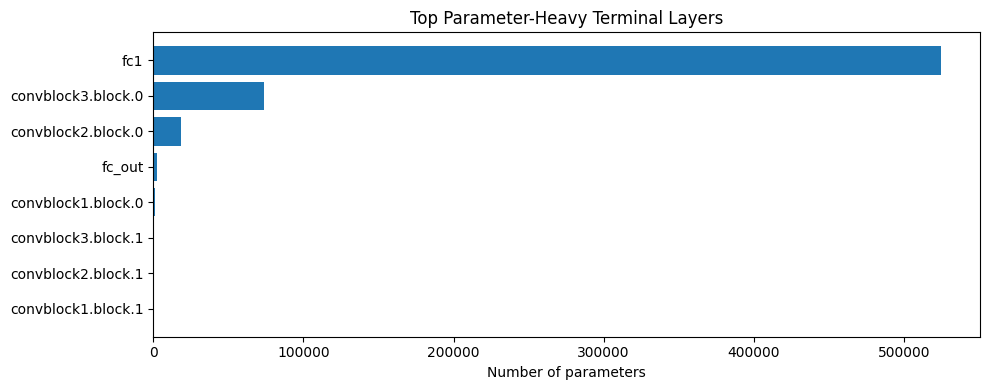

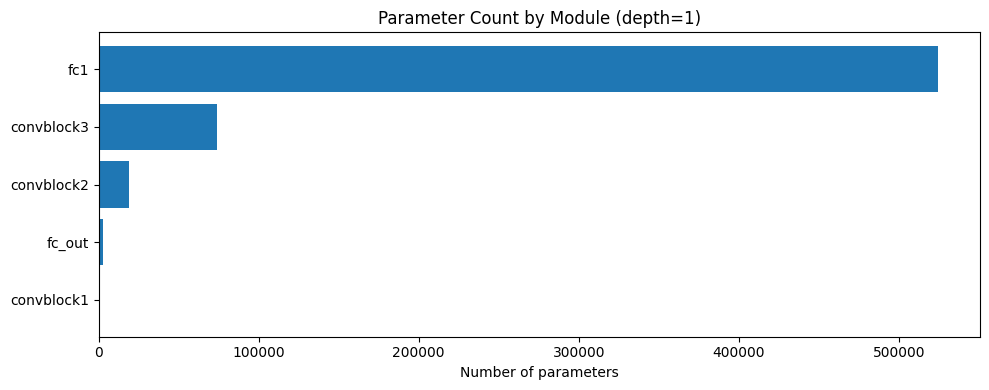

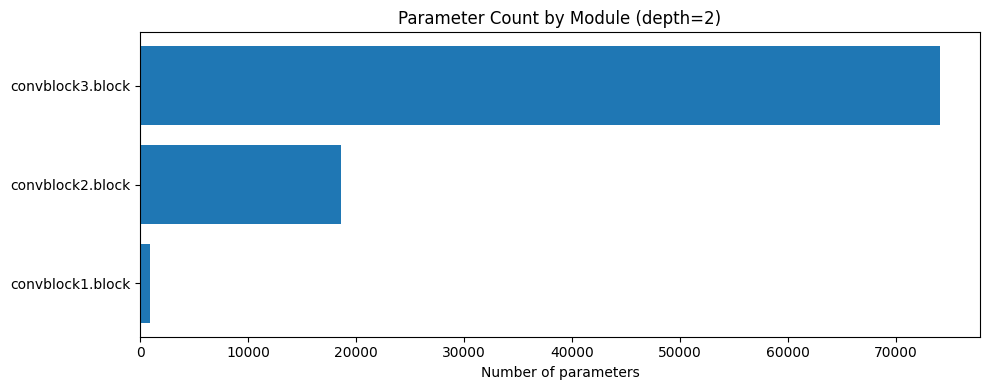

-----SHAPE TRACING-----

--- Shape Trace ---
convblock1.block.0                  in : (128, 3, 32, 32)
convblock1.block.0                  out: (128, 32, 32, 32)
convblock1.block.2                  in : (128, 32, 32, 32)
convblock1.block.2                  out: (128, 32, 32, 32)
convblock1.block.3                  in : (128, 32, 32, 32)
convblock1.block.3                  out: (128, 32, 16, 16)
convblock2.block.0                  in : (128, 32, 16, 16)
convblock2.block.0                  out: (128, 64, 16, 16)
convblock2.block.2                  in : (128, 64, 16, 16)
convblock2.block.2                  out: (128, 64, 16, 16)
convblock2.block.3                  in : (128, 64, 16, 16)
convblock2.block.3                  out: (128, 64, 8, 8)
convblock3.block.0                  in : (128, 64, 8, 8)
convblock3.block.0                  out: (128, 128, 8, 8)
convblock3.block.2                  in : (128, 128, 8, 8)
convblock3.block.2                  out: (128, 128, 8, 8)
convblock3.block.3 

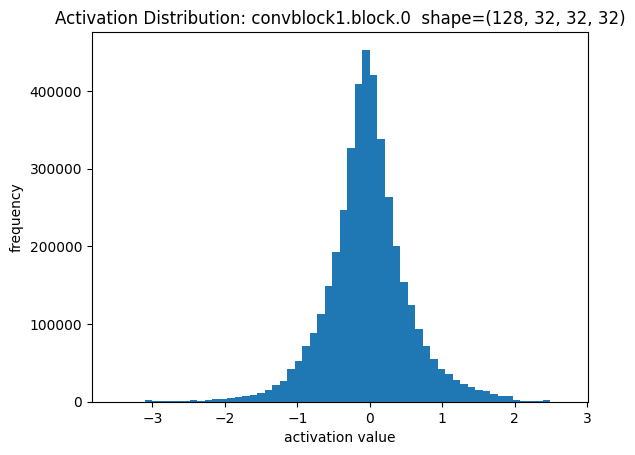

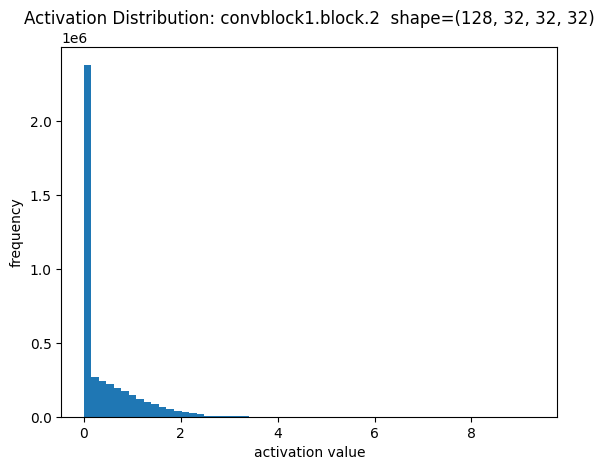

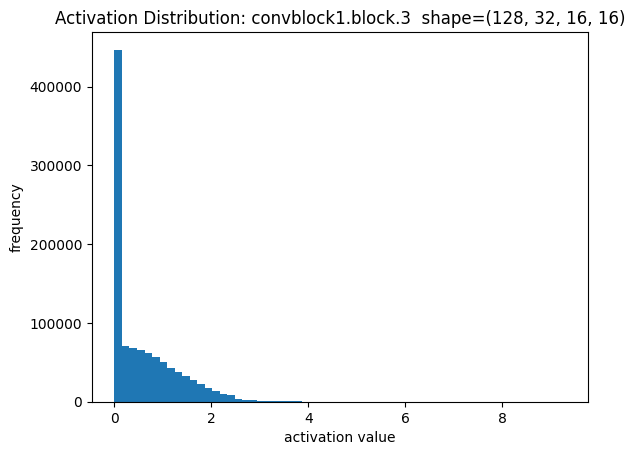

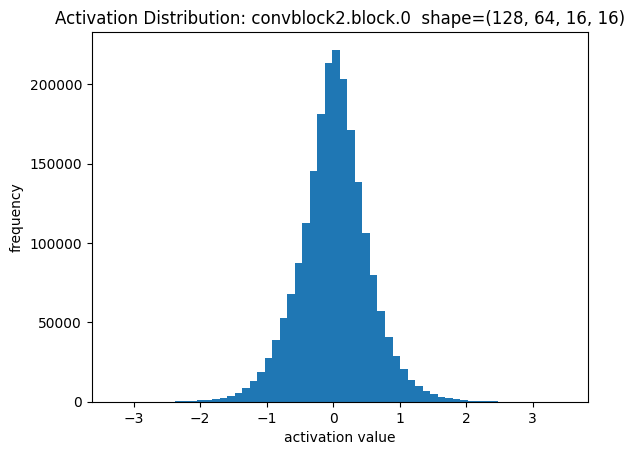

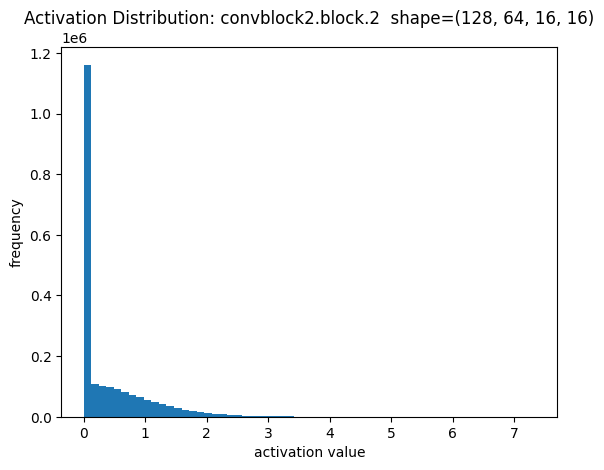

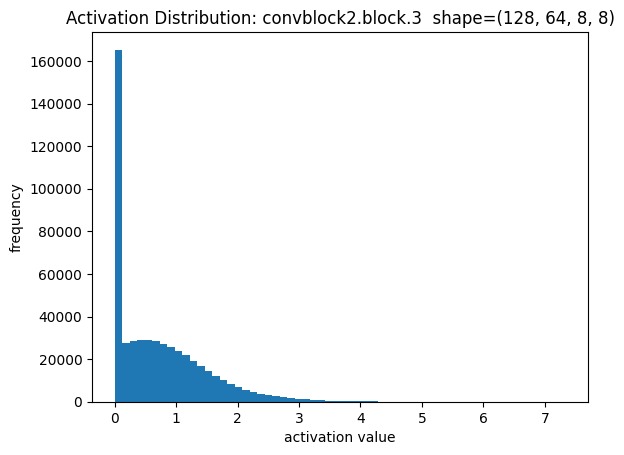

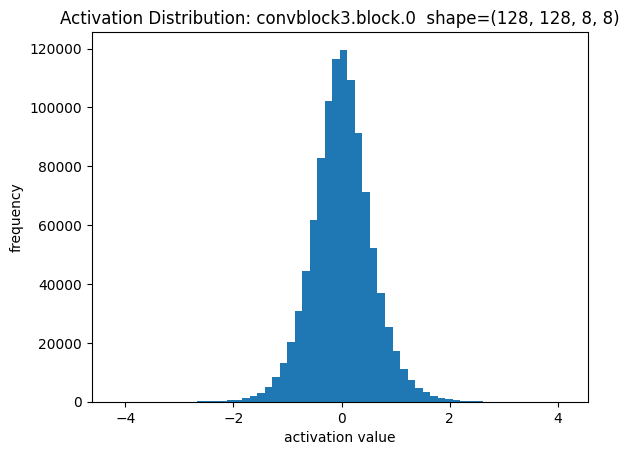

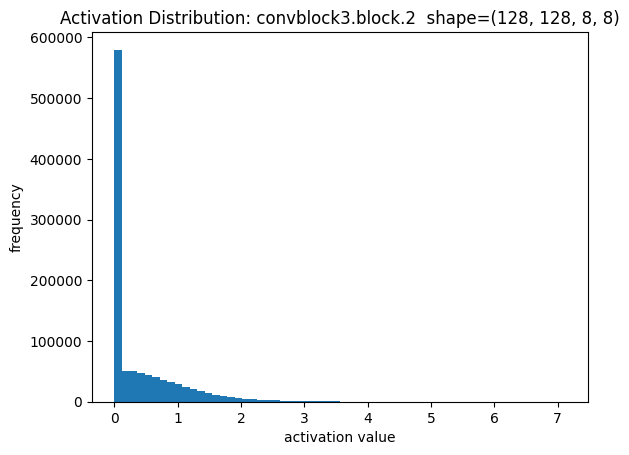

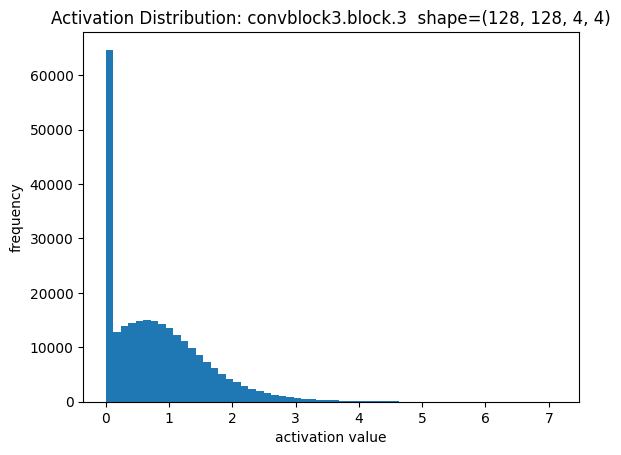

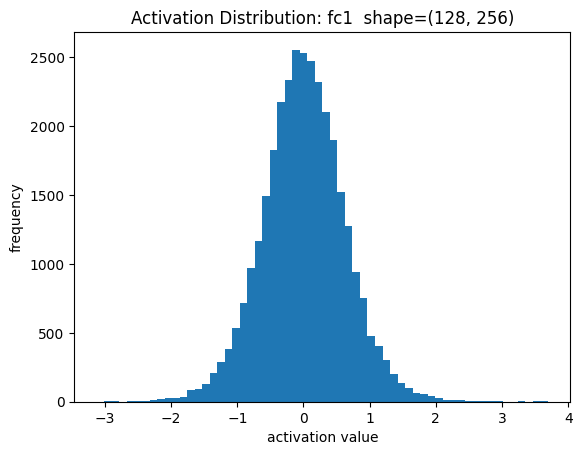

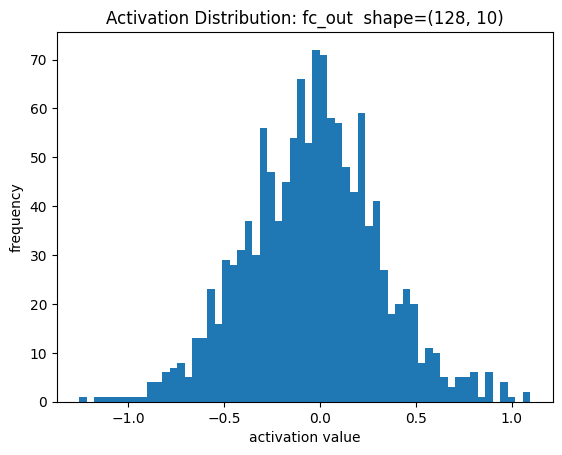


Conv-like layers found: ['convblock1.block.0', 'convblock1.block.2', 'convblock1.block.3', 'convblock2.block.0', 'convblock2.block.2', 'convblock2.block.3', 'convblock3.block.0', 'convblock3.block.2', 'convblock3.block.3']


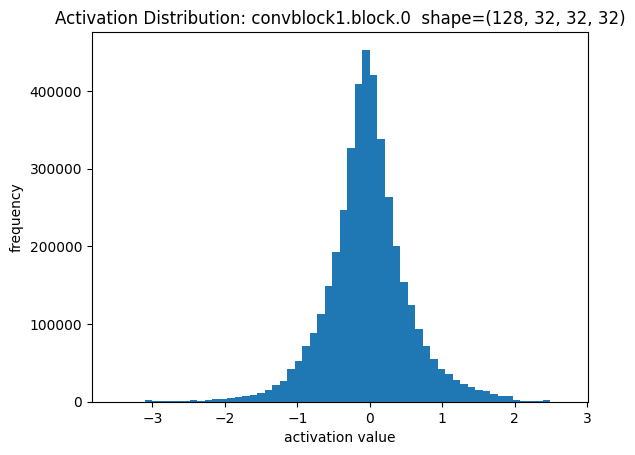

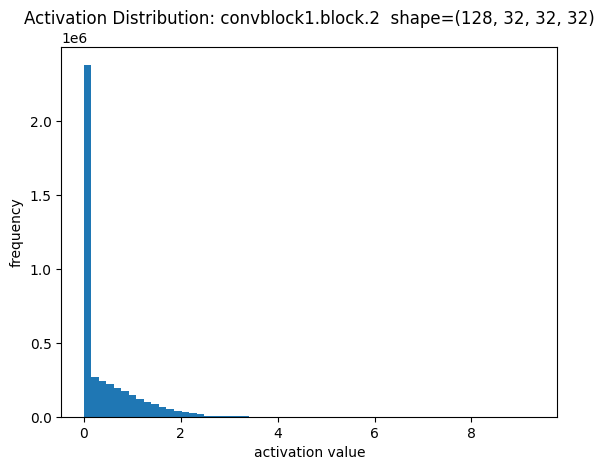

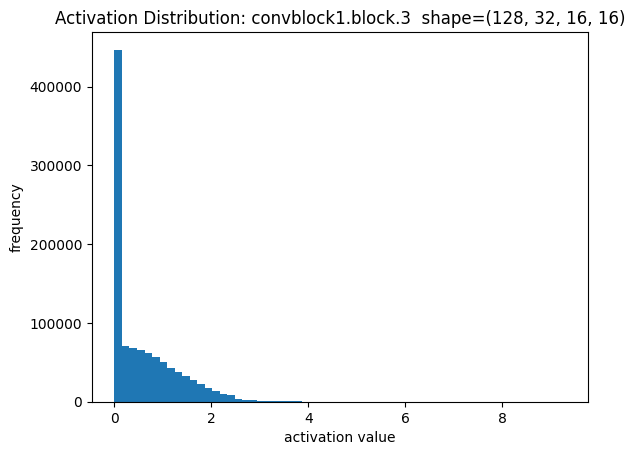

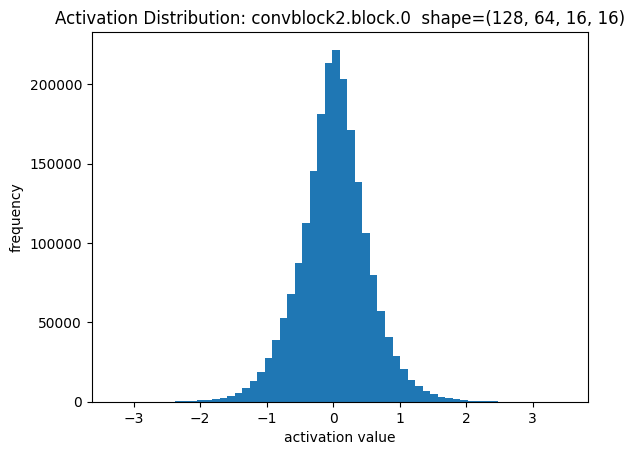

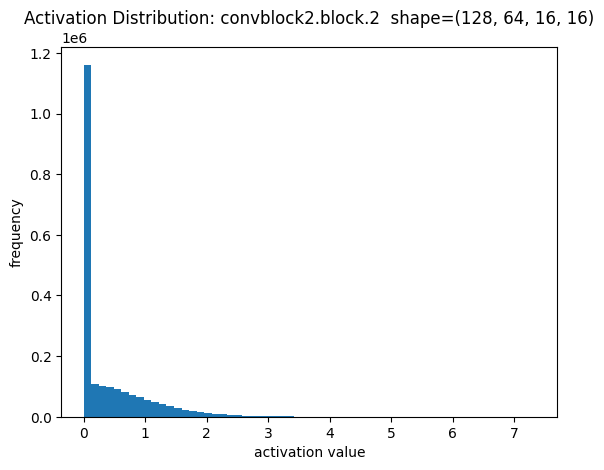

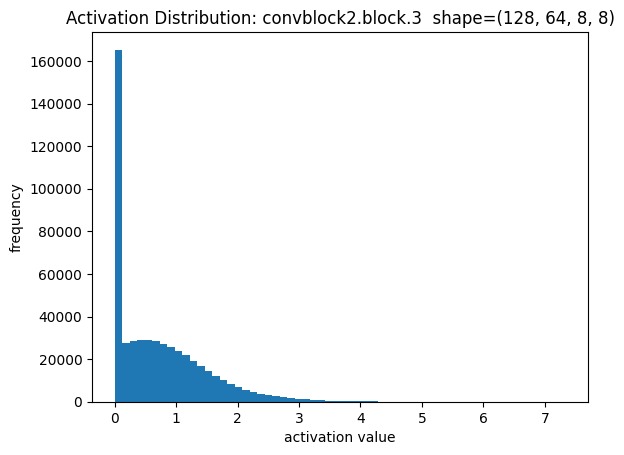

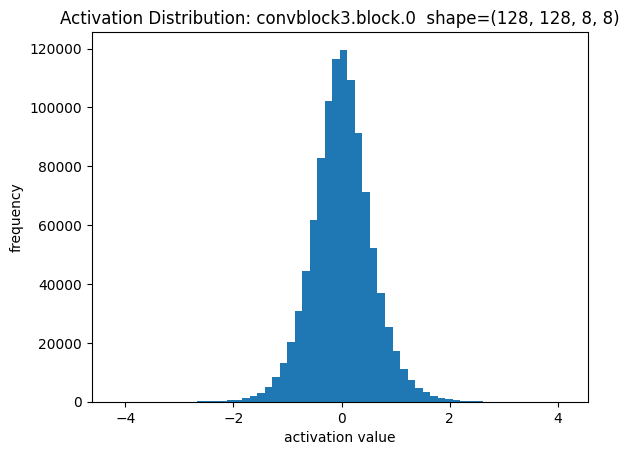

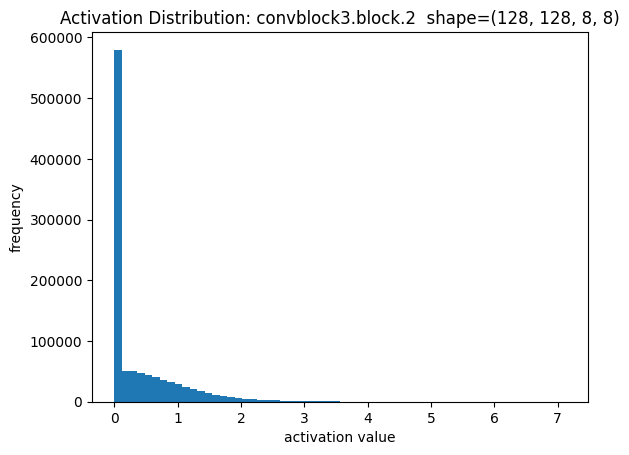

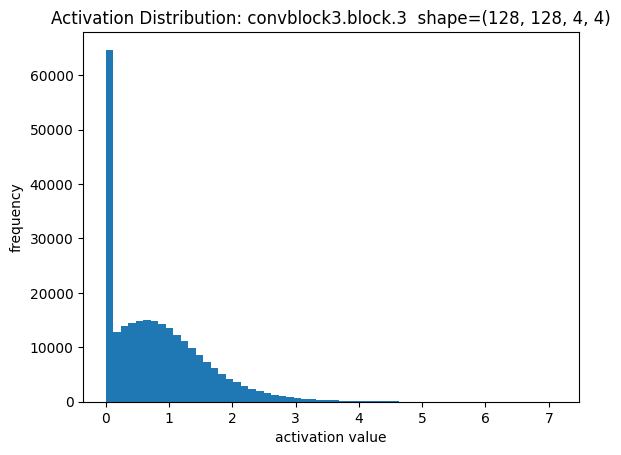

-----Diagnostic of per channel conv layer-----

--- Per-channel diagnostics for convblock1.block.0 ---


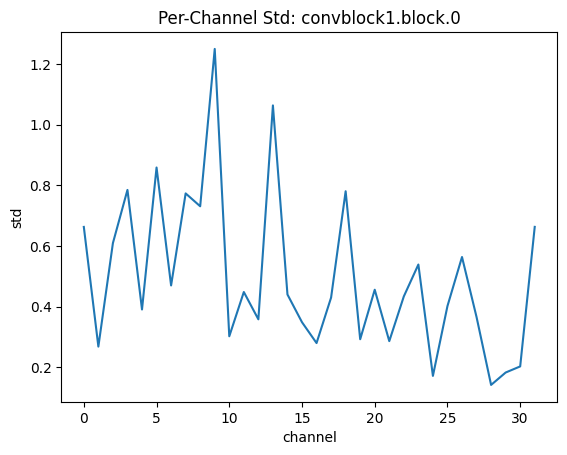

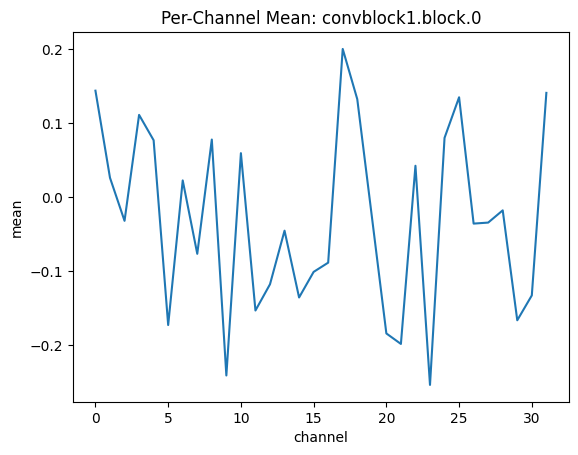

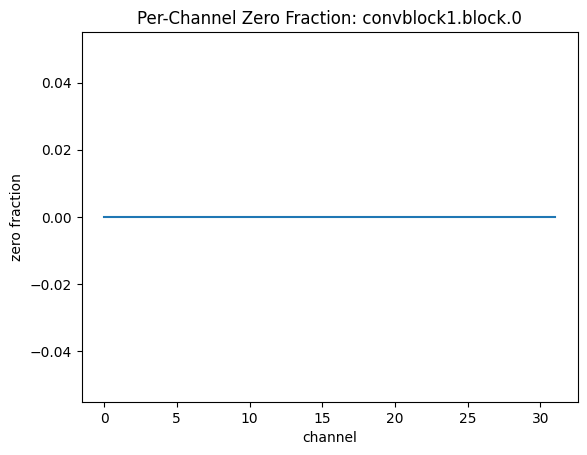

In [20]:
# Model Inspection and Analysis

from model_inspection import (
    count_parameters,
    count_parameters_in_module,
    print_named_parameters_shapes,
    print_top_level_children,
    print_all_modules,
    get_parameter_count_by_terminal_layer,
    get_parameter_count_by_named_module,
    plot_parameter_counts,
    ShapeTracer,
    ActivationLogger,
    plot_conv_per_channel_stats
)


### Initialize Model ### 
model = CNNModular()


### Basic Inspection ###
print("-----BASIC INSPECTION-----")
print("Total parameters:", count_parameters(model))
print("\n--- Named parameter shapes ---")
print_named_parameters_shapes(model)

print("\n--- Top-level children ---")
print_top_level_children(model)

print("\n--- All modules (for layer naming) ---")
print_all_modules(model)

counts = get_parameter_count_by_terminal_layer(model)

# Print a few
for name, n in sorted(counts.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(name, n)

# Plot top layers
plot_parameter_counts(
    counts,
    top_k=25,
    title="Top Parameter-Heavy Terminal Layers",
    log_scale=False
)

# depth=1: "features", "classifier" style
counts_depth1 = get_parameter_count_by_named_module(model, depth=1)
plot_parameter_counts(counts_depth1, top_k=20, title="Parameter Count by Module (depth=1)")

# depth=2: "features.0", "features.1", ...
counts_depth2 = get_parameter_count_by_named_module(model, depth=2)
plot_parameter_counts(counts_depth2, top_k=30, title="Parameter Count by Module (depth=2)")


### Shape Tracing ###
print("-----SHAPE TRACING-----")
tracer = ShapeTracer(model, layer_types=(nn.Conv2d, nn.MaxPool2d, nn.ReLU, nn.Flatten, nn.Linear))
tracer.register()

tracer.clear()
with torch.no_grad():
    _ = model(img_batch)

print("\n--- Shape Trace ---")
tracer.print()
tracer.remove()

### Activation stats + histograms (hook-based) ###
print("-----ACTIVATION STATISTICS AND PLOTS-----")
logger = ActivationLogger(
    model,
    layer_types=(nn.Conv2d, nn.ReLU, nn.MaxPool2d, nn.Linear),
    capture="output",
)
logger.register()

logger.clear()
with torch.no_grad():
    _ = model(img_batch)

print("\n--- Activation Stats (sorted by layer) ---")
logger.print_stats(sort_by="layer")

print("\n--- Activation Stats (sorted by zero_frac; dead ReLUs float up) ---")
logger.print_stats(sort_by="zero_frac")

print("\n--- Activation Histograms ---")
logger.plot_histograms(bins=60, clamp=None)

# If you only want conv layers:
conv_names = [n for n in logger.acts.keys() if "conv" in n.lower()]
print("\nConv-like layers found:", conv_names)
logger.plot_histograms(layer_names=conv_names, bins=60)


### Diagnostic of per channel conv layer ###
print("-----Diagnostic of per channel conv layer-----")
if len(conv_names) > 0:
    conv_layer_name = conv_names[0]
    conv_act = logger.acts[conv_layer_name]  # [N,C,H,W]
    print(f"\n--- Per-channel diagnostics for {conv_layer_name} ---")
    plot_conv_per_channel_stats(conv_act, conv_layer_name)

logger.remove()


In [ ]:
# Model Training

# TODO training diagnostics (inspect and viz)
# https://chatgpt.com/c/698a9fb1-b468-832b-a476-e70cec261a4c

# Model Evaluation

